## Interactive Model Training 
Run the cells to reproduce the results

### Data and Models Used in Hisia

**Data:** 2016 TrustPilot's 254,464 Danish reviews' body and stars and [8 fake reviews]*20 see notes for explanation.<br>
&ensp; _Update_: 2021-10-02: Political Data from [Sentiment Analysis on Comments from Danish Political Articles on Social Media](https://github.com/steffan267/Sentiment-Analysis-on-Danish-Social-Media)

**Models**<br>
Hisia, _LogisticRegression_ with SAGA, a variant of Stochastic Average Gradient (SAG), as solver. L2 penalty was select for base model. Test score **accurace is ca. 93%** and **recall of 93%**. SAGA is faster solver for large datasets (both rows and columns wise). As stochastic gradient, memory of previous grdient is incorporated/feed-forward to achieve faster convergence rate. Seeds of 42 was set in data split, and 42 in model for reproducibility.

HisiaTrain, _SGDClassifier_, Stochastic Gradient Descent learner with smooth loss 'modified_huber as loss function and L2 penalty. Test score **accurance  94%** and **recall of 94%**. SGDClassifier was select because of partial_fit. It allows batch/online training.

**Note:** This score reflects models in regards to TrustPilot reviews style of writing.<b>
 >8*10 fake reviews. TrustPilot reviews are directed toward products and services. Words like 'elsker'(love) or 'hader'(hate) are rarely used. To make sure the model learns such relationship, I added 8 reviews and duplicated them 10 times. This new sentences did not increase or decrease the model accurance but added correct coeffient of love, hate and (ikke dårligt) not bad.

In [3]:
%reload_ext watermark
%watermark -uniz --author "Author Prayson W. Daniel" -vm -p pandas,numpy,matplotlib,scikit-learn,lemmy,dill

Author: Author Prayson W. Daniel

Last updated: 2021-10-02T11:29:22.652215+02:00

Python implementation: CPython
Python version       : 3.7.11
IPython version      : 7.27.0

pandas      : 1.3.3
numpy       : 1.20.3
matplotlib  : 3.4.2
scikit-learn: 1.0
lemmy       : 2.1.0
dill        : 0.3.4

Compiler    : GCC 7.5.0
OS          : Linux
Release     : 5.4.0-86-generic
Machine     : x86_64
Processor   : x86_64
CPU cores   : 12
Architecture: 64bit



In [113]:
from collections import namedtuple
import joblib
import re
from pathlib import Path

import dill
import lemmy

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegressionCV
from loguru import logger

In [40]:
from helpers import show_diagram
from helpers import show_most_informative_features

In [6]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (15,5)
plt.style.use('fivethirtyeight')

This stops were custom made from both unknown Danish stops words and products and services related words such as delivery, package, post office.

In [23]:
PATH_TO_DATA = '../data'
PATH_TO_STOPWORDS = '../hisia/models/data'
STOP_WORDS = joblib.load(f'{PATH_TO_STOPWORDS}/stops.pkl')

The tokenizer separates emojis from the words, removes digits, repetive words and stop words and lemmatize words

In [46]:
lemmatizer = lemmy.load('da')


# Add more stopwords
STOP_WORDS.update({
    "kilometer",
})

In [48]:
"kilometer" in STOP_WORDS

True

In [25]:
def tokenizer(blob, stop_words=STOP_WORDS, remove_digits=True):
    
    if stop_words is None:
        stop_words = {}
    
    blob = blob.lower()
    
     # eyes [nose] mouth | mouth [nose] eyes pattern
    emoticons = r"(?:[<>]?[:;=8][\-o\*\']?[\)\]\(\[dDpP/\:\}\{@\|\\]|[\)\]\(\[dDpP/\:\}\{@\|\\][\-o\*\']?[:;=8][<>]?)"
    emoticon_re = re.compile(emoticons, re.VERBOSE | re.I | re.UNICODE)
    
    text = re.sub(r'[\W]+', ' ', blob)
    
    # remove 3+ repetitive characters i.e. hellllo -> hello, jaaaa -> jaa 
    repetitions = re.compile(r'(.)\1{2,}')
    text = repetitions.sub(r'\1\1', text)
    
    # remove 2+ repetitive words e.g. hej hej hej -> hej
    
    repetitions = re.compile(r'\b(\w+)\s+(\1\s*)+\b')
    text = repetitions.sub(r'\1 ', text)
    
    
    # 14år --> 14 år
    text = re.sub(r'([0-9]+(\.[0-9]+)?)', r' \1 ', text).strip()
    
    emoji = ''.join(re.findall(emoticon_re, blob))
    
       
    # remove stopwords
    text_nostop = [word for word in text.split() if word not in stop_words]
    
    # tokenization lemmatize
    lemmatized_text = [lemmatizer.lemmatize('', word)[-1]  
                                 for word in text_nostop]
    
    remove_stopwords = ' '.join(word for word in lemmatized_text if len(word)>1)
    
    if remove_digits:
        remove_stopwords = re.sub(r'\b\d+\b', '', remove_stopwords)
    

    # remove extra spaces
    remove_stopwords = ' '.join(remove_stopwords .split())
    result = f'{remove_stopwords} {emoji}'.encode('utf-8').decode('utf-8')
       
    
    return result.split()

In [21]:
tokenizer('Jeg er vred på, at jeg ikke fik min pakke :( kilometer')

['vred', 'ikke', ':(']

In [26]:
df = pd.read_json(f'{PATH_TO_DATA}/data.json')

Fake reviews to teach our model the missing relationsh that is not found in TP reviews

In [27]:
dt = pd.DataFrame([('men elsker elsker', 1,5), 
                   ('elsker det ikke', 0, 1), 
                   ('ikke dårligt', 1, 5),
                   ('elsker skat, kæreste, tilbedte, dyrebare, elskling, darling, hjerte, hjertenskær; ven; veninde', 1, 5),
                   ('dårlig: syg, sløj, utilpas, ilde tilpas, upasselig, snavs, indisponeret;'
                    'sygelig, usund, ond, slet; arg, uheldig, umulig, elendig, under al kritik,'
                    'dødssyg, skidt, skral, krank, ussel, ikke noget at samle på, talentløs, uantagelig,'
                    'uacceptabel, forkastelig; ikke noget at råbe hurra for, ikke noget at skrive hjem om,'
                    'noget skidt (lort, pis), andenklasses, tredjeklasses (osv.), ringe, halvgod, ikke nogen'
                    'ørn til, ikke ens stærke side, ens svage punkt, som en brækket arm; sjusket; ufordelagtig,'
                    'ufyldestgørende, utilstrækkelig, utilfredsstillende, middelmådig, under lavmålet, uduelig,'
                    'udygtig, uhensigtsmæssig, forkert, tarvelig; skadelig, ødelæggende, fordærvet, ubrugelig;'
                    'ubehagelig, væmmelig, ulystbetonet; dys-; utiltalende, usympatisk, kedelig', 0, 1),
                    ('20.000 kroner. Det er, hvad man som arbejdstager burde få ekstra i lønningsposen,'
                    ' hvis man skal kunne acceptere at have en dårlig chef.', 0,1),
                   ('kærlighed, hvordan elsker vi hinanden godt – uanset hvem vi elsker?',1,5),
                   ('jeg hader dig', 0, 1),
                   
                  ]*20, 
                  columns='features target stars'.split())

In [29]:
# new data from "Sentiment Analysis on Comments from Danish Political Articles on Social Media"
# source: [https://github.com/lucaspuvis/SAM/blob/master/Thesis.pdf]

In [118]:
SAM = "https://raw.githubusercontent.com/steffan267/Sentiment-Analysis-on-Danish-Social-Media/master/all_sentences.csv"
ds = pd.read_csv(SAM, names=["target", "features"])

In [119]:
ds['target'].value_counts()

 0    4087
-1    2610
 1    1007
-2     862
 2     442
Name: target, dtype: int64

In [122]:
ls ../data

data_custom.json  data.json


In [74]:
(ds
  .loc[lambda d: d['target'].ne(0)]
  .assign(target= lambda d: np.where(d["target"].gt(0), 1, 0))
       
)['target'].value_counts()
  

0    3472
1    1449
Name: target, dtype: int64

In [76]:
ds = (ds
  .loc[lambda d: d['target'].ne(0)]
  .assign(target= lambda d: np.where(d["target"].gt(0), 1, 0))
       
)[['features', 'target']]
  

In [77]:
dt = dt.append(ds ,ignore_index=True)

In [9]:
# dt.to_json('../data/data_custom.json')

In [78]:
X_train, X_test, y_train, y_test = train_test_split(df['features'], 
                                                     df['target'],
                                                     test_size=.2,
                                                     random_state=42,
                                                     stratify=df['target'])

In [79]:
X_train, y_train = (X_train.append(dt['features'],ignore_index=True),
                    y_train.append(dt['target'],ignore_index=True)
)

In [80]:
print(f'Traing Size: {X_train.shape[0]}\nTest Size: {X_test.shape[0]:>8}')
print(f'\nTraing Size\n\tPositive||Negative Samples\n\t  {y_train[y_train==1].shape[0]}||{y_train[y_train==0].shape[0]}')
print(f'\nTest Size\n\tPositive||Negative Samples\n\t  {y_test[y_test==1].shape[0]}||{y_test[y_test==0].shape[0]}')

Traing Size: 208652
Test Size:    50893

Traing Size
	Positive||Negative Samples
	  103315||105337

Test Size
	Positive||Negative Samples
	  25446||25447


In [82]:
hisia = Pipeline(steps =[
        ('count_verctorizer',  CountVectorizer(ngram_range=(1, 2), 
                                 max_features=150000,
                                 tokenizer=tokenizer, 
                                 stop_words=STOP_WORDS
                                )
        ),
        ('feature_selector', SelectKBest(chi2, k=10000)),
        ('tfidf', TfidfTransformer(sublinear_tf=True)),
        ('logistic_regression', LogisticRegressionCV(cv=5,
                                                    solver='saga',
                                                    scoring='accuracy',
                                                    max_iter=500, 
                                                    n_jobs=-1,
                                                    random_state=42,
                                                    verbose=0))
])

In [83]:
%%time
hisia.fit(X_train, y_train)

/home/pwd/miniconda/envs/hisia/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['alme', 'bank', 'brand', 'dansk', 'presi'] not in stop_words.
  % sorted(inconsistent)
/home/pwd/miniconda/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/pwd/miniconda/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/pwd/miniconda/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  ConvergenceWarning,
/home/pwd/miniconda/envs/hisia/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:354: Conver

CPU times: user 15min 39s, sys: 357 ms, total: 15min 39s
Wall time: 3min 41s


Pipeline(steps=[('count_verctorizer',
                 CountVectorizer(max_features=150000, ngram_range=(1, 2),
                                 stop_words={'ad', 'af', 'alle', 'alm brand',
                                             'alt', 'anden', 'andet', 'andre',
                                             'at', 'bare', 'begge', 'besked',
                                             'bestil', 'bestild', 'bestilde',
                                             'bestilden', 'bestilder',
                                             'bestildt', 'bestildte', 'bestile',
                                             'bestilede', 'bestiler',
                                             'bestilet', 'bestilg', 'bestilge',
                                             'bestiling', 'besti...
                                             'bestilinger', 'bestilings',
                                             'bestilingsforløbet', ...},
                                 tokenizer=<function token

In [84]:
hisia.score(X_test, y_test)

0.9389699958736958

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.93      0.95      0.94     25447
    Positive       0.95      0.93      0.94     25446

    accuracy                           0.94     50893
   macro avg       0.94      0.94      0.94     50893
weighted avg       0.94      0.94      0.94     50893

	 _____________________________________________ 




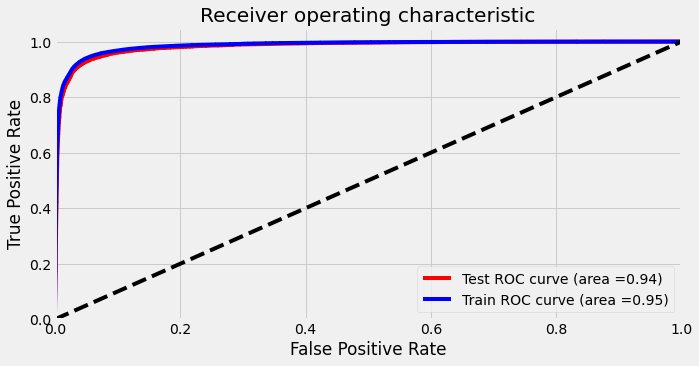

<Figure size 1080x360 with 0 Axes>

In [85]:
show_diagram(hisia, X_train, y_train, X_test, y_test, compare_test=True)

In [86]:
feature_names = hisia.named_steps['count_verctorizer'].get_feature_names_out()
best_features = [feature_names[i] for i in hisia.named_steps['feature_selector'].get_support(indices=True)]
predictor =  hisia.named_steps['logistic_regression']

In [87]:
N = 100
print(f'Showing {N} models learned features for negative and postive decisions')
print('_'*70)
print('\n')
show_most_informative_features(best_features, predictor, n=N)

Showing 100 models learned features for negative and postive decisions
______________________________________________________________________


	-9.7232	ikke orden     		8.8140	perfekt        
	-9.0674	uacceptabel    		8.1560	super          
	-8.9552	dårlig         		7.9428	ingen problem  
	-7.3875	elendig        		7.9240	god            
	-6.6214	ikke anbefale  		7.6891	aldrig problem 
	-6.4598	ikke god       		7.5472	fin            
	-6.2382	ikke modtage   		7.3699	nem            
	-6.0722	ikke iorden    		7.3042	hurtig         
	-5.9351	stadig ikke    		6.9676	:-)            
	-5.7788	øv             		6.8729	dejlig         
	-5.7776	ikke tilfreds  		6.8706	tilfreds       
	-5.7103	forkert        		6.7399	sidste stjerne 
	-5.5596	umulig         		6.3951	hurtigt        
	-5.4718	ingen hjælpe   		6.3223	fantastisk     
	-5.4141	opsige         		6.1161	fremragende    
	-5.3991	påstå          		6.0472	ingen klage    
	-5.3258	trætte         		5.6006	varm anbefale  
	-5.2227	ingen måde    

In [94]:
# [negative, positive] probability
hisia.predict_proba(['det er ikke okay!'])

array([[0.92140274, 0.07859726]])

In [89]:
hisia.predict_proba(['det er ikke dårligt!'])

array([[0.31872416, 0.68127584]])

In [93]:
(hisia.predict_proba(['jeg kan lide det!']), 
 hisia.predict_proba(['jeg kan ikke det!']),
 hisia.predict_proba(['jeg elsker det!']),
 hisia.predict_proba(['jeg elsker det slet ikke!'])
)

(array([[0.30786518, 0.69213482]]),
 array([[0.92140274, 0.07859726]]),
 array([[0.144568, 0.855432]]),
 array([[0.68955267, 0.31044733]]))

In [95]:
mad_max = ['Jeg er vred på, at jeg ikke fik min pakke :( elsker']

In [96]:
hisia.named_steps['logistic_regression'].random_state

42

In [97]:
hisia.predict_proba(['']) # model is positive :)

array([[0.30786518, 0.69213482]])

In [98]:
hisia.predict(mad_max)

array([0])

In [99]:
res = hisia.predict_proba(mad_max)
res

array([[0.94054261, 0.05945739]])

In [100]:
hisia.decision_function(mad_max)

array([-2.76119702])

In [101]:
v = hisia.named_steps['count_verctorizer'].transform(mad_max)
v = hisia.named_steps['feature_selector'].transform(v)
v = pd.DataFrame.sparse.from_spmatrix(v)

In [102]:
v = set(v.loc[:,v.iloc[0]==1].columns)

In [103]:
look_up = {index:(token,coef) for index, coef, token in 
           zip(range(len(best_features)),
               hisia.named_steps['logistic_regression'].coef_[0], 
               best_features)}

In [104]:
{look_up[item] for item in v}

{(':(', -4.369068341969313),
 ('elsker', 0.967737847205695),
 ('ikke', -3.271679111316931),
 ('vred', -2.330453428360274)}

In [105]:
hisia.named_steps['logistic_regression'].intercept_[0]

0.8101187848146085

In [106]:
g = [look_up[item] for item in v]

In [107]:
1/(1 + np.exp(-(g[0][1] + g[1][1] + hisia.named_steps['logistic_regression'].intercept_[0])))

0.36526214251202355

In [108]:
hisia.decision_function(mad_max)[0]

-2.761197015688508

In [109]:
df = pd.DataFrame(res)

In [110]:
df['sentiment'] = np.where(df[0] > .5, 'negative', 'positive')

In [111]:
df.columns = ['negative_probability','positive_probability','sentiment']

In [114]:
Sentiment = namedtuple('Sentiment', ['sentiment','positive_probability', 'negative_probability'])

In [115]:
df

,negative_probability,positive_probability,sentiment
0,0.940543,0.059457,negative


In [116]:
b = Sentiment(**df.round(3).to_dict(orient='index')[0])

In [117]:
b

Sentiment(sentiment='negative', positive_probability=0.059, negative_probability=0.941)

# Retrainable Model SGD

In [43]:
hisia_trainer =Pipeline(steps =[
                ('count_verctorizer',  CountVectorizer(ngram_range=(1, 2), 
                                         max_features=100000,
                                         tokenizer=tokenizer, 
                                        )
                ),
                ('feature_selector', SelectKBest(chi2, k=5000)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('modified_hubern', SGDClassifier(loss='modified_huber', 
                                                      random_state=7,
                                                      max_iter=1000))
])

In [44]:
%%time
hisia_trainer.fit(X_train, y_train)

CPU times: user 2min 12s, sys: 4.55 s, total: 2min 17s
Wall time: 2min 29s


Pipeline(steps=[('count_verctorizer',
                 CountVectorizer(max_features=100000, ngram_range=(1, 2),
                                 tokenizer=<function tokenizer at 0x7f299e7665f0>)),
                ('feature_selector',
                 SelectKBest(k=5000,
                             score_func=<function chi2 at 0x7f29a0f484d0>)),
                ('tfidf', TfidfTransformer(sublinear_tf=True)),
                ('modified_hubern',
                 SGDClassifier(loss='modified_huber', random_state=7))])

In [45]:
# for partil_fit we have to split the pipeline to transformation and scoring
hisia_trainer.score(X_test,y_test)

0.9352366730198652

Classification Report
	 _____________________________________________
              precision    recall  f1-score   support

    Negative       0.92      0.95      0.94     25447
    Positive       0.95      0.92      0.93     25446

    accuracy                           0.94     50893
   macro avg       0.94      0.94      0.94     50893
weighted avg       0.94      0.94      0.94     50893

	 _____________________________________________ 




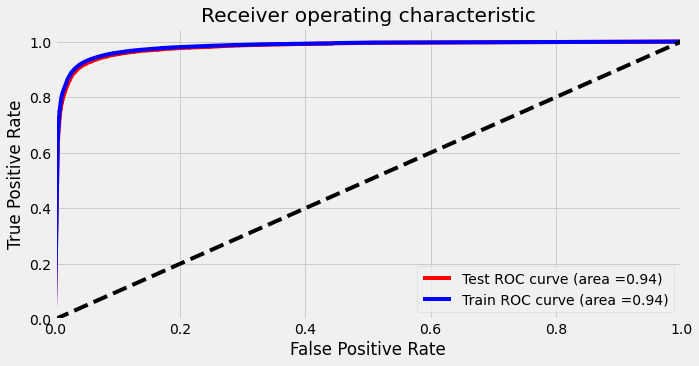

<Figure size 1080x360 with 0 Axes>

In [46]:
show_diagram(hisia_trainer, X_train, y_train, X_test, y_test, compare_test=True)

In [47]:
feature_names = hisia_trainer.named_steps['count_verctorizer'].get_feature_names()
best_features = [feature_names[i] for i in hisia_trainer.named_steps['feature_selector'].get_support(indices=True)]
predictor =  hisia_trainer.named_steps['modified_hubern']

In [48]:
N = 100
print(f'Showing {N} models learned features for negative and postive decisions')
print('_'*70)
print('\n')
show_most_informative_features(best_features, predictor, n=N)

Showing 100 models learned features for negative and postive decisions
______________________________________________________________________


	-2.5134	dårlig         		2.2176	god            
	-1.8454	ikke orden     		2.0373	hurtig         
	-1.7522	uacceptabel    		2.0333	super          
	-1.7472	elendig        		2.0238	perfekt        
	-1.6706	kilometer      		1.9283	nem            
	-1.6391	ikke god       		1.8499	fin            
	-1.6088	først          		1.8285	dejlig         
	-1.4937	forkert        		1.7523	:-)            
	-1.4503	langsom        		1.7110	tilfreds       
	-1.4139	ikke tilfreds  		1.6985	hurtigt        
	-1.3812	ikke modtage   		1.5544	fantastisk     
	-1.3790	betale         		1.4693	:)             
	-1.3671	øv             		1.2569	smile          
	-1.3622	forsøge        		1.2289	venlig         
	-1.3486	uge            		1.2043	ikke dårlig    
	-1.2826	ødelægge       		1.1629	fremragende    
	-1.2769	:-(            		1.1304	ingen problem  
	-1.2717	trætte        